In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.matlib import empty
from pandas.core.interchange.dataframe_protocol import DataFrame
import os
import os.path
import shutil


plt.rcParams['font.sans-serif']=['Songti SC'] #用来正常显示中文标签

def read_tbm_data(file_path):
    '''
    读取TBM数据文件
    参数:
        file_path: 文件路径
    返回:
        df: 处理后的DataFrame
    '''
    #读取第一行，防止列名数和列数不匹配
    # 读取数据，使用制表符分隔
    df = pd.read_csv(file_path, sep='\t',index_col=False)
    df = df.loc[:,['时间戳','运行时间','刀盘转速','推进速度','刀盘扭矩','贯入度','总推进力','推进速度电位器设定值']]
    return df

def tbm_cycle_judge(df,buffer_size = 300,threshold = 0.1):
    #可以添加条件(df['总推进力']>0)
    df['is_extract'] = (df["刀盘转速"]>0) & (df["刀盘扭矩"]>0) & (df["贯入度"]<=20) &(df["贯入度"]>0)
    df['运行时间'] = pd.to_datetime(df['运行时间'])
    df.sort_values('运行时间',inplace = True)

    #缓冲区buffer_size = 300
    #设定阈值用以判断一个小窗口是否符合，比例大于90%则认为是稳定掘进状态,threshold = 0.1
    #利用滑动窗口来判断掘进循环
    df["smoothing"] = False
    #df.rolling()在整个dataframe上使用rolling函数，再调用is_extract列来取窗口平均值判定
    extract_mean = df.rolling(window=60, on='运行时间', closed='both')['is_extract'].mean()
    df['smoothing'] = extract_mean > threshold


    #找到smoothing由false转换为true的那部分（起始索引）,并利用缓冲区往前延伸
    smoothing_shift = df['smoothing'].shift(1,fill_value=False)
    smoothing_starts = df[(df['smoothing'] == False) & (smoothing_shift == True)].index
    for start_idx in smoothing_starts:
        buffer_start = max(start_idx-buffer_size, 0)
        df.loc[buffer_start:start_idx,'smoothing'] = True

    #检测状态变化
    df['cycle_id'] = (df['smoothing']!=df['smoothing'].shift(1)).cumsum()
    #仅保留掘进状态的循环
    excavation_cycles = df[df['smoothing']].groupby('cycle_id')
    #过滤掉时长不足600s的循环
    valid_cycle = []
    duration = 0
    for cycle_id , cycle in excavation_cycles:
        duration = len(cycle)
        if duration > 600:
            valid_cycle.append({"cycle_id": cycle_id,
                               'starttime': cycle['运行时间'].iloc[0],
                               'endtime' :cycle['运行时间'].iloc[-1],
                               'duration': duration,
            })
    return valid_cycle


def display(valid_cycle,tbm_para,df):
    cycle_df = pd.DataFrame(valid_cycle)
    for index ,cycle in cycle_df.iterrows():
        #找出每个循环段的开始和截止时间，以及持续时间
        cycle_id = cycle['cycle_id']
        start = cycle['starttime']
        end = cycle['endtime']
        duration = cycle['duration']
        #提取，并且利用这个把需要的数据筛选出来
        #cycle_data = df[(df['运行时间']>=end - pd.Timedelta(minutes=35)) & (df['运行时间'] <= end)]
        #cycle_data = df[(df['运行时间']>=start-pd.Timedelta(minutes=1)) & (df['运行时间'] <= end)]
        cycle_data = df[(df['运行时间']>=start) & (df['运行时间'] <= end)]
        #绘制图像
        plt.figure(dpi = 200)
        plt.plot(cycle_data['运行时间'],cycle_data[tbm_para],'b',label = f'Cycle{cycle_id}')
        plt.xlabel('运行时间')
        plt.ylabel(tbm_para)
        plt.title('{}-掘进时间关系图'.format(tbm_para))
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation = 90)
        plt.tight_layout()
        plt.show()

'''
异常值判定和处理
对于掘进过程中的极大异常点,采用 3σ准则判定。
通过计算整个掘进步贯入度和掘进速度的均值μ和标准差σ,当掘进速度和贯入度大于μ+ 3σ时,则按照异常点处理。
对识别出来的异常点,取5个临近数据点的平均值替代。
数据平滑处理
为了消除掘进参数中的白噪声,本文采用滑动均值滤波来处理。取窗口长度为n,从第一个数据点开始,计算相邻的n个数据点的算术平均值并作为该点滤波之后的新值,
均值滤波的窗口长度决定影响该点数值的数据范围,当选择较大的窗口长度时,可得到更加平滑曲线,但是忽视了很多数据的变化细节,如果选择的窗口长度过小,则噪声消除的效果不够理想。本文采用的滤波窗口长度为15s。
'''
def handle_outlier_data(df,valid_cycle,col_name,outlier_window):
    #这里写3sigma处理的算法
    cycle_df = pd.DataFrame(valid_cycle)
    for index,cycle in cycle_df.iterrows():
        cycle_id = cycle['cycle_id']
        start = cycle['starttime']
        end = cycle['endtime']
        cycle_data = df[(df['运行时间']>=start-pd.Timedelta(minutes=1)) & (df['运行时间'] <= end)]
        mu = cycle_data[col_name].mean()
        sigma = cycle_data[col_name].std()
        outlier = df[df[col_name] > (3*sigma + mu)]
        for idx in outlier.index:
            start_idx =max(idx - outlier_window, 0)
            end_idx = min(len(df),idx + outlier_window)
            df.at[idx,col_name] = (df.loc[start_idx:idx-1,col_name].mean()+df.loc[idx+1:end_idx,col_name].mean()+mu)/3.0
    return df

def smooth_data(df,valid_cycle,col_name,smooth_window):
    #这里写smooth处理的方法
    cycle_df = pd.DataFrame(valid_cycle)
    for index,cycle in cycle_df.iterrows():
        cycle_id = cycle['cycle_id']
        start = cycle['starttime']
        end = cycle['endtime']
        cycle_data = df[(df['运行时间']>=start-pd.Timedelta(minutes=1)) & (df['运行时间'] <= end)]
        temp = cycle_data[col_name].rolling(window=smooth_window,min_periods=1,center=True).mean()
        df.loc[cycle_data.index,col_name] = temp
    return df

def data_presv(df,valid_cycle,col_names = ['推进速度','贯入度'],outlier_window=20,smooth_window = 15):
    #调用上面的两个函数
    for col in col_names:
        df = handle_outlier_data(df,valid_cycle,col,outlier_window)
        df = smooth_data(df,valid_cycle,col,smooth_window)
    return df

In [3]:
def classify_excavation_phase(df,cycle_list,T_threshold = 0,Tf_threshold = 600,Ff_threshold = 1000,sigma_threshold = 100,duration_threshold = 200,v_set_rate = 0.1):
    #T_threshold = 0
    #Tf_threshold = 600
    #Ff_threshold = 1000
    #duration_threshold = 60
    phase_list = []
    cycle_list = pd.DataFrame(cycle_list)
    for index,cycle in cycle_list.iterrows():
        cycle_id = cycle['cycle_id']
        start = cycle['starttime']
        end = cycle['endtime']
        cycle_data = df[(df['运行时间']>=start-pd.Timedelta(minutes=1)) & (df['运行时间'] <= end)].copy()

        #空推段
        push_start = cycle_data[cycle_data['刀盘扭矩']>T_threshold].index
        push_start_time = cycle_data.at[push_start[0],'运行时间'] if not push_start.empty else None

        #上升段
        rising_start = cycle_data[(cycle_data['刀盘扭矩'] > Tf_threshold) & (cycle_data['总推进力'] > Ff_threshold)].index
        rising_start_time = cycle_data.at[rising_start[0],'运行时间'] if not rising_start.empty else None

        #稳定段
        #stable_phase_data = cycle_data[cycle_data['运行时间'] > rising_start_time].copy()
        cycle_data['v_std'] = cycle_data['推进速度'].rolling(window = 60,min_periods=1).std()
        cycle_data['v_set_std'] = cycle_data['推进速度电位器设定值'].rolling(window = 30,min_periods=1).std()
        cycle_data['v_set_m'] = cycle_data['推进速度电位器设定值'].rolling(window = 60,min_periods=1).mean()

        #动态阈值设定，防止返回none
        #sigma_threshold = cycle_data['v_set_std'].mean()*sigma_threshold
        v_set_threshold = cycle_data['v_set_m']*v_set_rate

        #条件为设定10%的阈值+利用设定推进速度的sigma来判断
        conditions = (cycle_data['v_set_std']<=sigma_threshold)&(cycle_data['推进速度电位器设定值']>cycle_data['v_set_std']*10)
        #conditions = (cycle_data['v_set_std']<=sigma_threshold)(cycle_data['推进速度']>v_set_threshold)

        cycle_data['is_stable_candidate'] = conditions
        #检查是否有duration_threshold的持续稳定，文中设定为60s
        stable_candidates = cycle_data[(cycle_data['is_stable_candidate']) & (cycle_data['运行时间']>rising_start_time+pd.Timedelta(minutes=1))].copy()
        #stable_candidates = cycle_data[cycle_data['v_set_std'] <= sigma_threshold].copy()
        stable_candidates['diff'] = stable_candidates['运行时间'].diff().dt.total_seconds()
        stable_candidates['group'] = (stable_candidates['diff'] > 3).cumsum()
        stable_groups = stable_candidates.groupby('group')

        stable_start_time = rising_start_time
        for group_id, group in stable_groups:
            duration = (group['运行时间'].iloc[-1] - group['运行时间'].iloc[0]).total_seconds()
            if duration >= duration_threshold:
                stable_start_time = group['运行时间'].iloc[0]
                break
        #下降段
        falling_start = cycle_data[(cycle_data['运行时间'] > stable_start_time)&(cycle_data['刀盘扭矩'] <= Tf_threshold) &(cycle_data['总推进力'] <= Ff_threshold)].index

        #falling_start = cycle_data[(cycle_data['刀盘扭矩'] <= Tf_threshold) &(cycle_data['总推进力'] <= Ff_threshold)].index
        falling_start_time = cycle_data.at[falling_start[0], '运行时间'] if not falling_start.empty else None

        phases = {
                'cycle_id': cycle_id,
                'push_start': push_start_time,
                'rising_start': rising_start_time,
                'stable_start': stable_start_time,
                'falling_start': falling_start_time
            }
        phase_list.append(phases)


    return phase_list


In [4]:
def plot_cycle_phases(df, phase_list, tbm_param='刀盘扭矩', buffer_minutes=0):
    '''
    绘制每个有效循环的图像，并标记各阶段起点
    参数:
        df: DataFrame，包含原始数据。
        phase_list: 阶段划分后的列表，每个元素包含 cycle_id 和各阶段的起点时间。
        tbm_param: 要绘制的参数列名（如'刀盘扭矩'、'推进速度'）。
        buffer_minutes: 缓冲区时间（分钟）。
    '''
    for phase in phase_list:
        cycle_id = phase['cycle_id']
        push_start = phase['push_start']
        rising_start = phase['rising_start']
        stable_start = phase['stable_start']
        falling_start = phase['falling_start']

        # 定义循环的开始和结束时间，包含缓冲区前1分钟
        # 假设 cycle['starttime'] 和 cycle['endtime'] 存在
        # 但在 phase_list 中只有 'push_start', 'rising_start' 等
        # 所以需要根据具体情况调整
        # 这里假设 'push_start' 是循环的开始
        start_time = push_start - pd.Timedelta(minutes=buffer_minutes) if push_start else None
        # 结束时间可以根据数据范围或其他逻辑确定
        # 这里假设循环结束时间为 'falling_start' 后的某个时间点
        end_time = falling_start + pd.Timedelta(minutes=buffer_minutes) if falling_start else None

        # 提取循环数据
        if start_time and end_time:
            cycle_data = df[(df['运行时间'] >= start_time) & (df['运行时间'] <= end_time)].copy()
        elif start_time:
            cycle_data = df[df['运行时间'] >= start_time].copy()
        elif end_time:
            cycle_data = df[df['运行时间'] <= end_time].copy()
        else:
            cycle_data = df.copy()

        # 检查是否有数据
        if cycle_data.empty:
            print(f"Cycle {cycle_id} has no data in the specified time range.")
            continue

        # 绘制参数曲线
        plt.figure(figsize=(12, 6),dpi=200)
        plt.plot(cycle_data['运行时间'], cycle_data[tbm_param], label=f'Cycle {cycle_id} {tbm_param}')

        # 标记各阶段起点
        if push_start:
            plt.axvline(push_start, color='green', linestyle='--', label='空推段起点')
        if rising_start:
            plt.axvline(rising_start, color='orange', linestyle='--', label='上升段起点')
        if stable_start:
            plt.axvline(stable_start, color='blue', linestyle='--', label='稳定段起点')
        if falling_start:
            plt.axvline(falling_start, color='red', linestyle='--', label='下降段起点')

        plt.xlabel('运行时间')
        plt.ylabel(tbm_param)
        plt.title(f'{tbm_param} - 掘进时间关系图 (Cycle {cycle_id})')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [5]:
import shutil

In [6]:
def unzip_file(zip_path = '/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data' ,unzip_path = '/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/un_zip',type = '.zip'):
    #确保输出文件夹存在
    chdir = os.chdir(zip_path)
    if not os.path.exists(unzip_path):
        try:
            os.mkdir(unzip_path)
        except Exception as e:
            print(f'无法创建目标文件夹{unzip_path}')
    for file in os.listdir(zip_path):
        if file.endswith(type):
            shutil.unpack_archive(file,unzip_path)

In [14]:
unzip_file()

In [15]:
print(os.listdir('/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/un_zip'))

['CREC188_20150713.txt', 'CREC188_20150707.txt', 'CREC188_20150712.txt', 'CREC188_20150710.txt', 'CREC188_20170629.txt', 'CREC188_20150711.txt', 'CREC188_20150708.txt', 'CREC188_20150709.txt']


In [16]:
list_of_bc = os.listdir('/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/un_zip')

In [17]:
list_of_bc

['CREC188_20150713.txt',
 'CREC188_20150707.txt',
 'CREC188_20150712.txt',
 'CREC188_20150710.txt',
 'CREC188_20170629.txt',
 'CREC188_20150711.txt',
 'CREC188_20150708.txt',
 'CREC188_20150709.txt']

In [18]:
for file in list_of_bc:
    print(file)

CREC188_20150713.txt
CREC188_20150707.txt
CREC188_20150712.txt
CREC188_20150710.txt
CREC188_20170629.txt
CREC188_20150711.txt
CREC188_20150708.txt
CREC188_20150709.txt


In [19]:
def save_process(df,phase_list,output_folder):
    all_cycle_data = []
    for phase in phase_list:
        cycle_id = phase['cycle_id']
        push_start = phase['push_start']
        rising_start = phase['rising_start']
        stable_start = phase['stable_start']
        falling_start = phase['falling_start']

        buffer_minutes = 0
        start_time = push_start - pd.Timedelta(minutes=buffer_minutes) if push_start else None
        end_time = falling_start + pd.Timedelta(minutes=buffer_minutes) if falling_start else None

        #标记空推段，只需要用上升段预测稳定段
        push_data = df[(df['运行时间']>push_start)&(df['运行时间']<rising_start)]
        rising_data = df[(df['运行时间']>rising_start)&(df['运行时间']<stable_start)]
        stable_data = df[(df['运行时间']>stable_start)&(df['运行时间']<falling_start)]
        falling_data = df[(df['运行时间']>falling_start)&(df['运行时间']<end_time)]


        rising_data['cycle_id'] = cycle_id
        stable_data['cycle_id'] = cycle_id
        rising_data['phase_label'] = 'rising'
        stable_data['phase_label'] = 'stable'

        all_cycle_data.append(rising_data)
        all_cycle_data.append(stable_data)
    os.makedirs(output_folder,exist_ok = True)
    basename = 'data'
    output_path = os.path.join(output_folder,f'{basename}_process.csv')
    if all_cycle_data:
        combined_df = pd.concat(all_cycle_data,ignore_index=True)
        #确保有输出文件夹
        if not os.path.exists(output_folder):
            combined_df.to_csv(path_or_buf=output_path,index = False,mode='w')
        else:
            #文件已经存在跳过header
            combined_df.to_csv(path_or_buf=output_path,index = False,mode='a')

/var/folders/2b/lrgpb6l56qq7z0p0v5dqkb7h0000gn/T/ipykernel_4624/3935521446.py:24: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(file_path, sep='\t',index_col=False)
/var/folders/2b/lrgpb6l56qq7z0p0v5dqkb7h0000gn/T/ipykernel_4624/438363201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rising_data['cycle_id'] = cycle_id
/var/folders/2b/lrgpb6l56qq7z0p0v5dqkb7h0000gn/T/ipykernel_4624/438363201.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

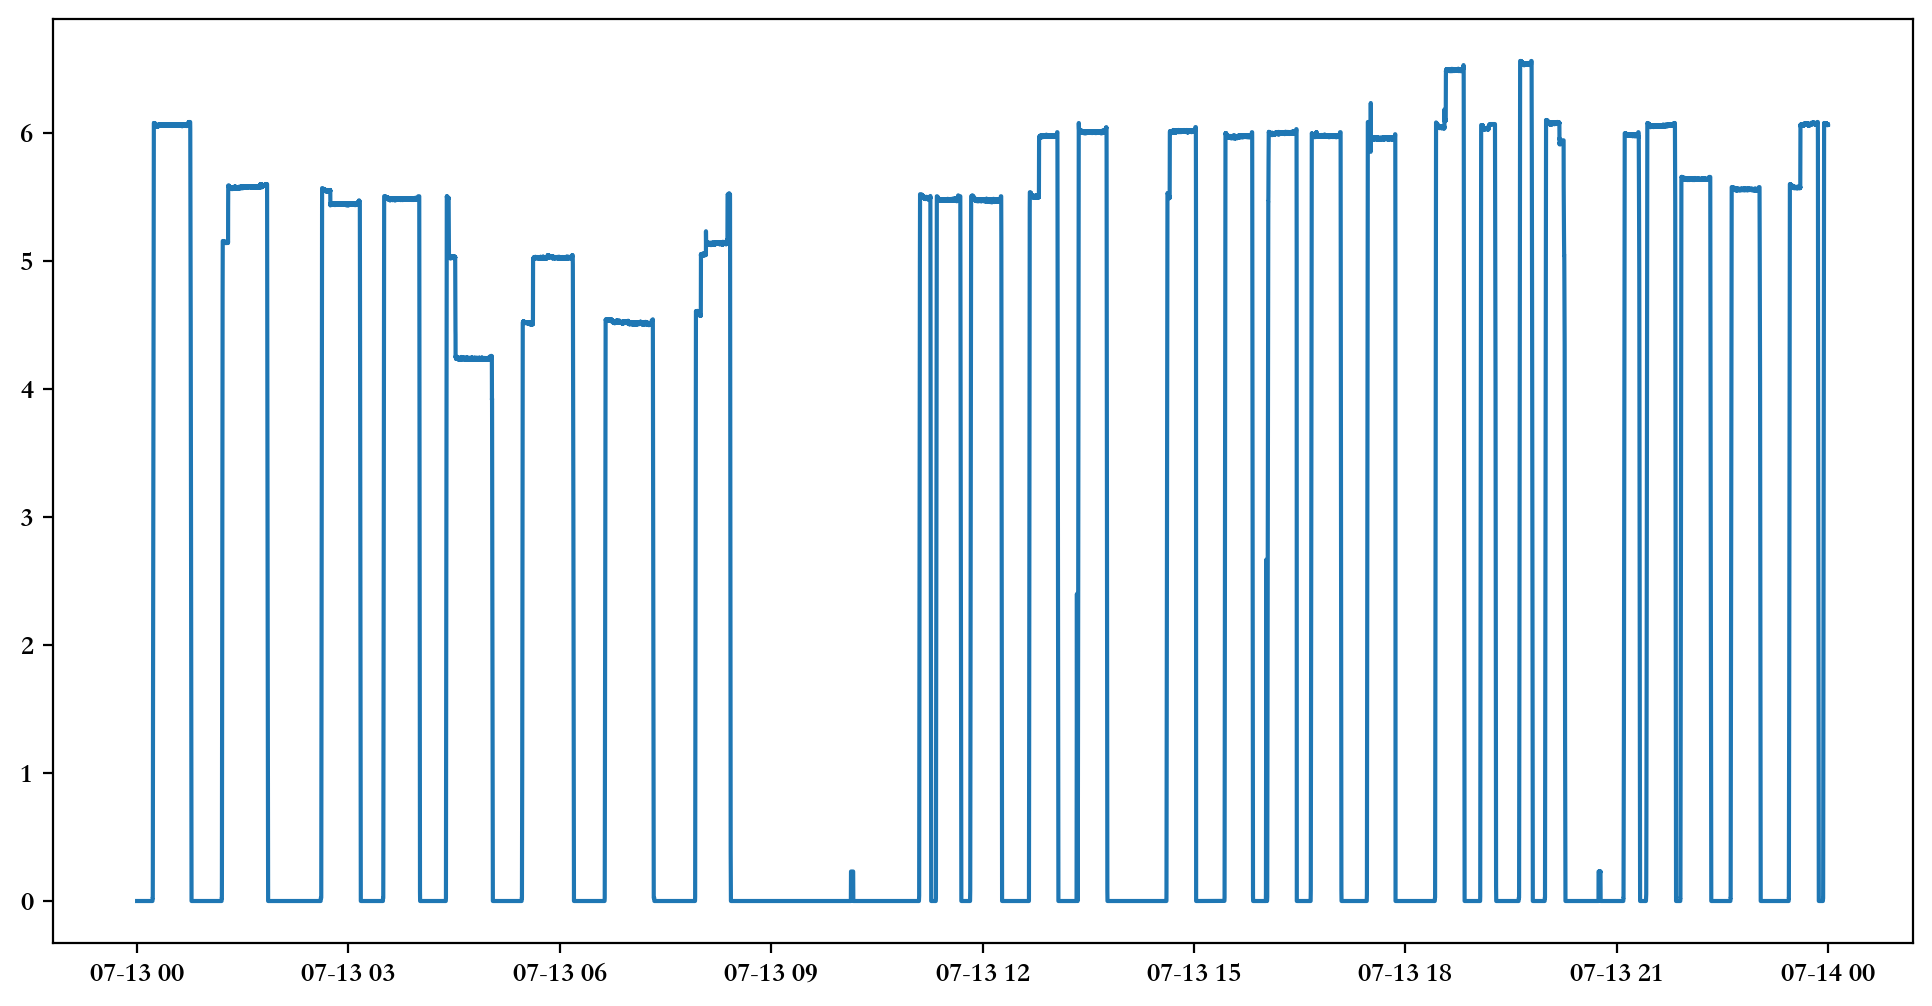

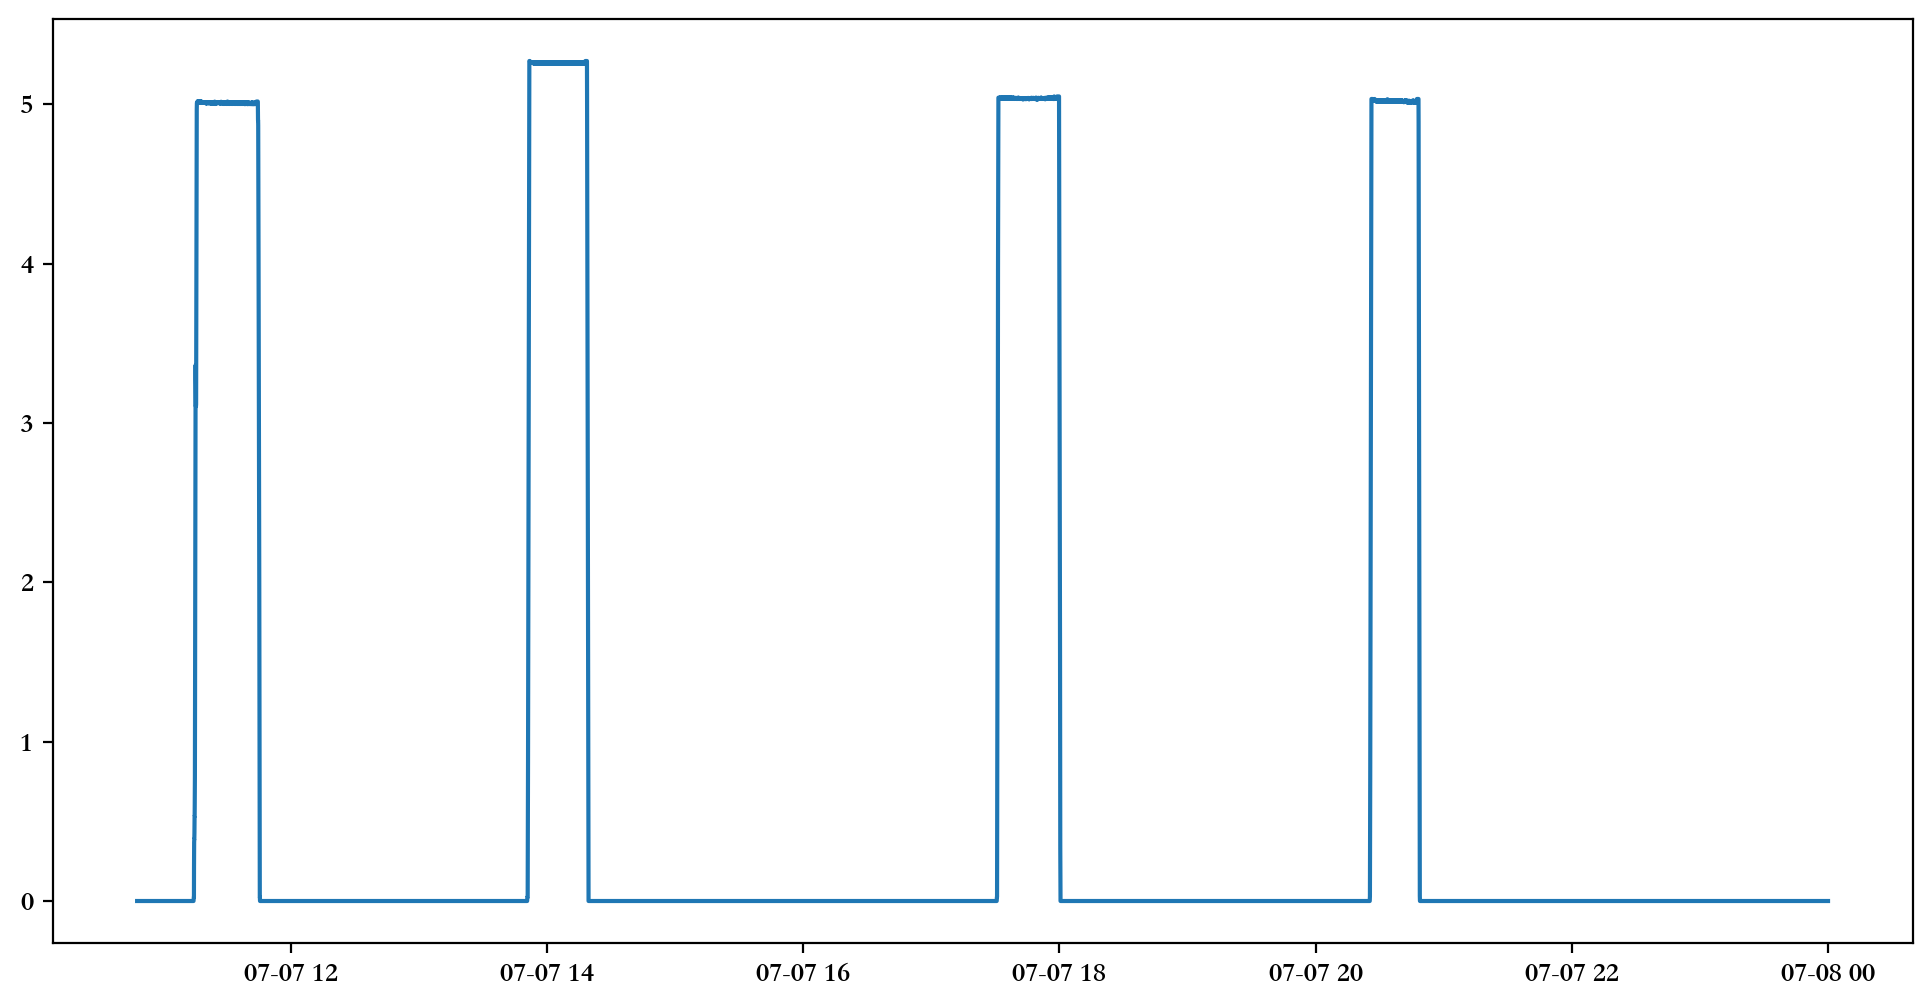

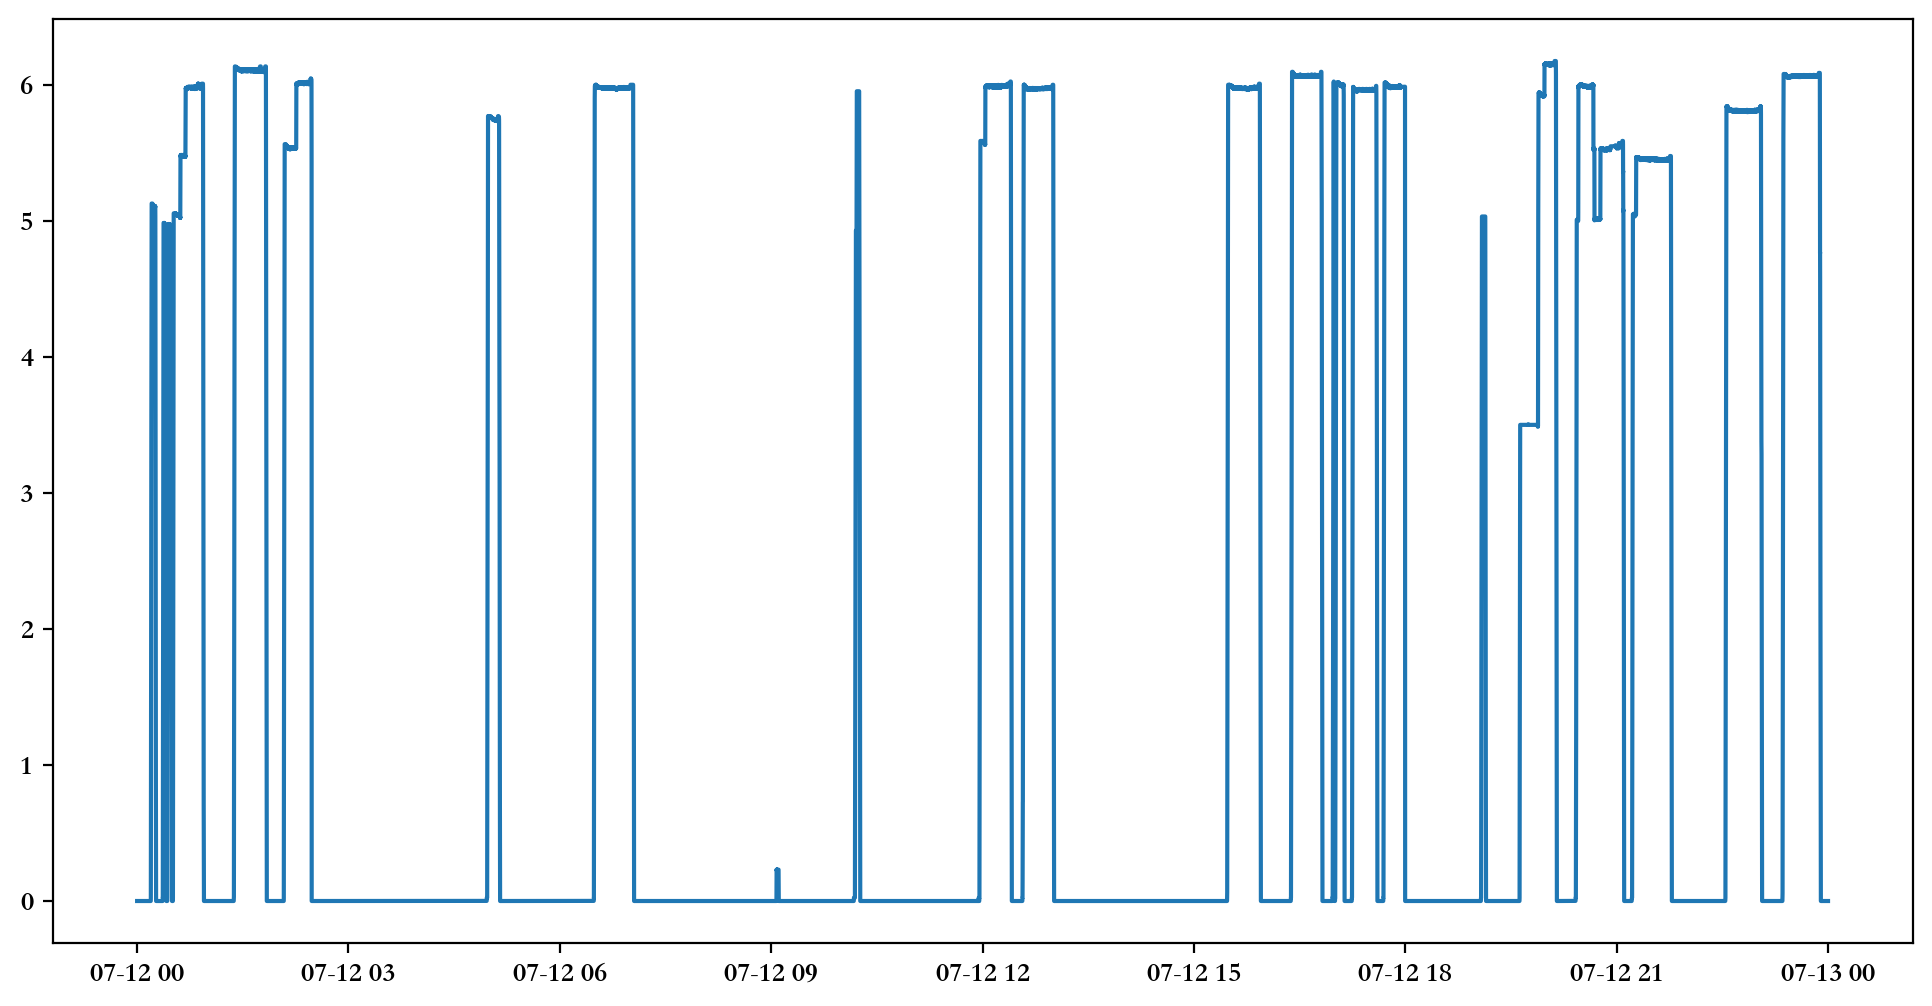

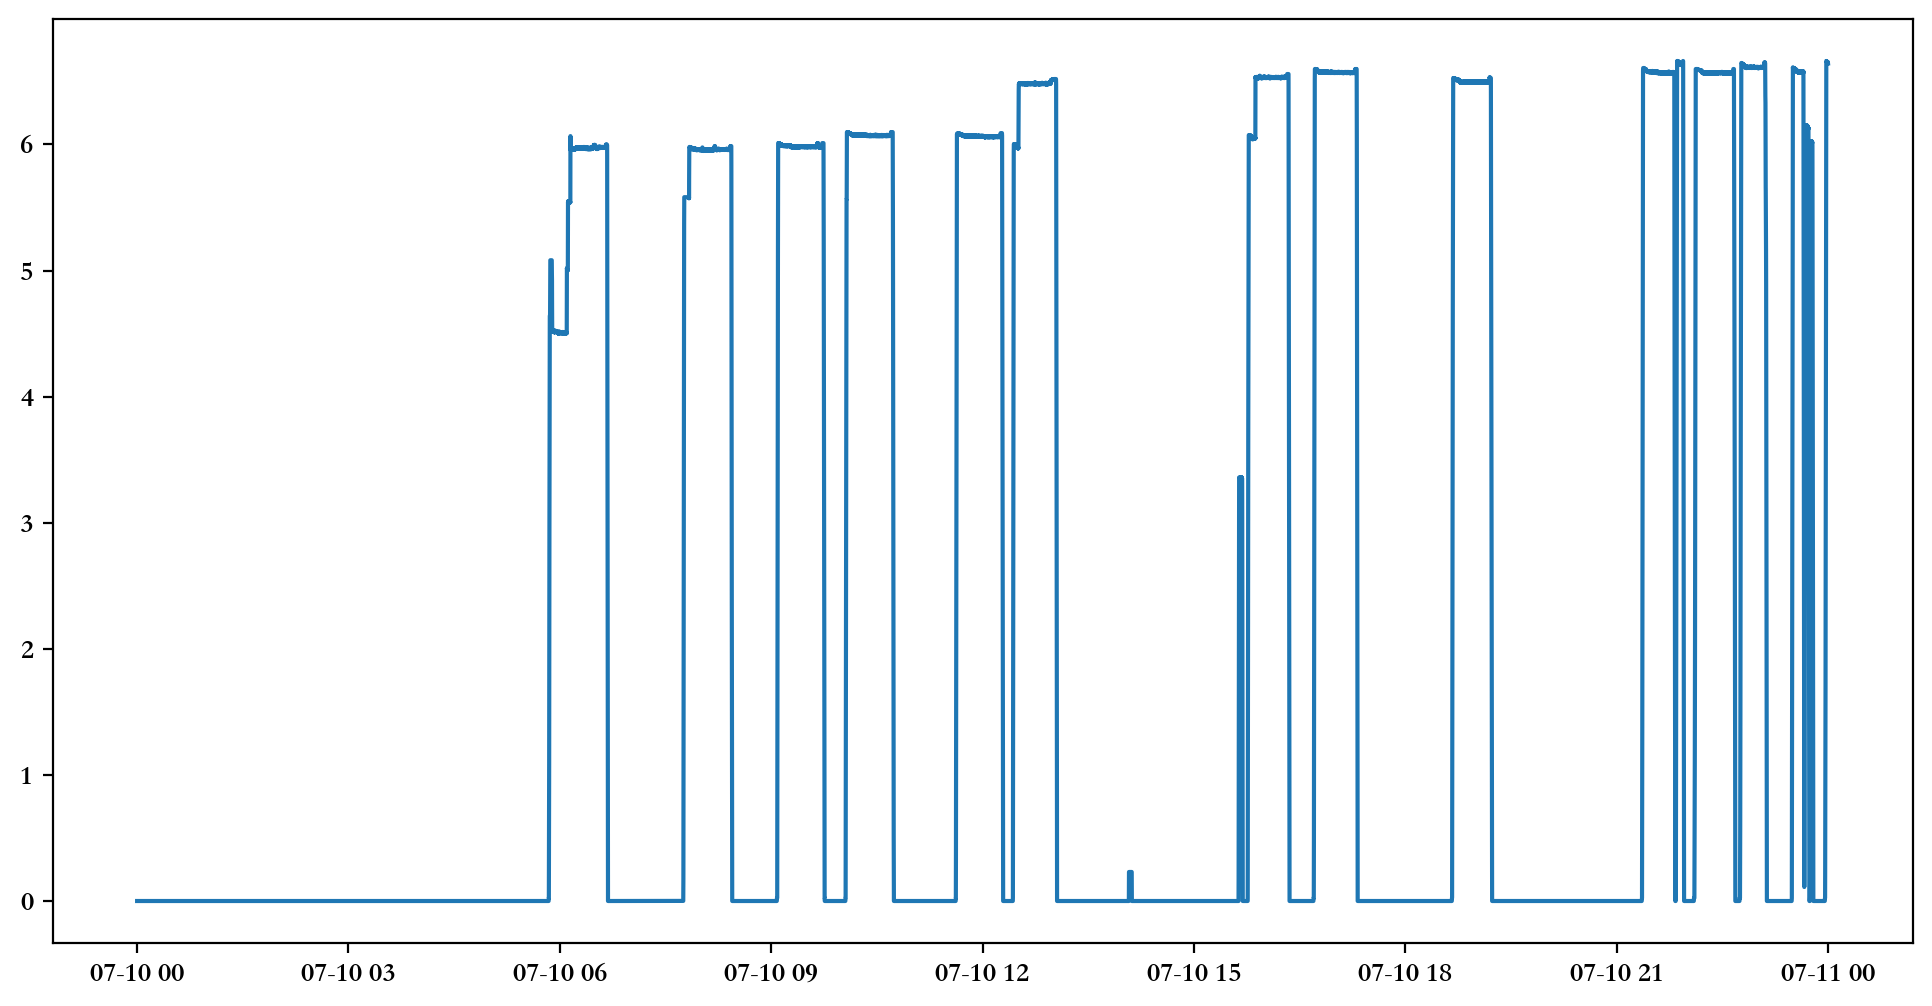

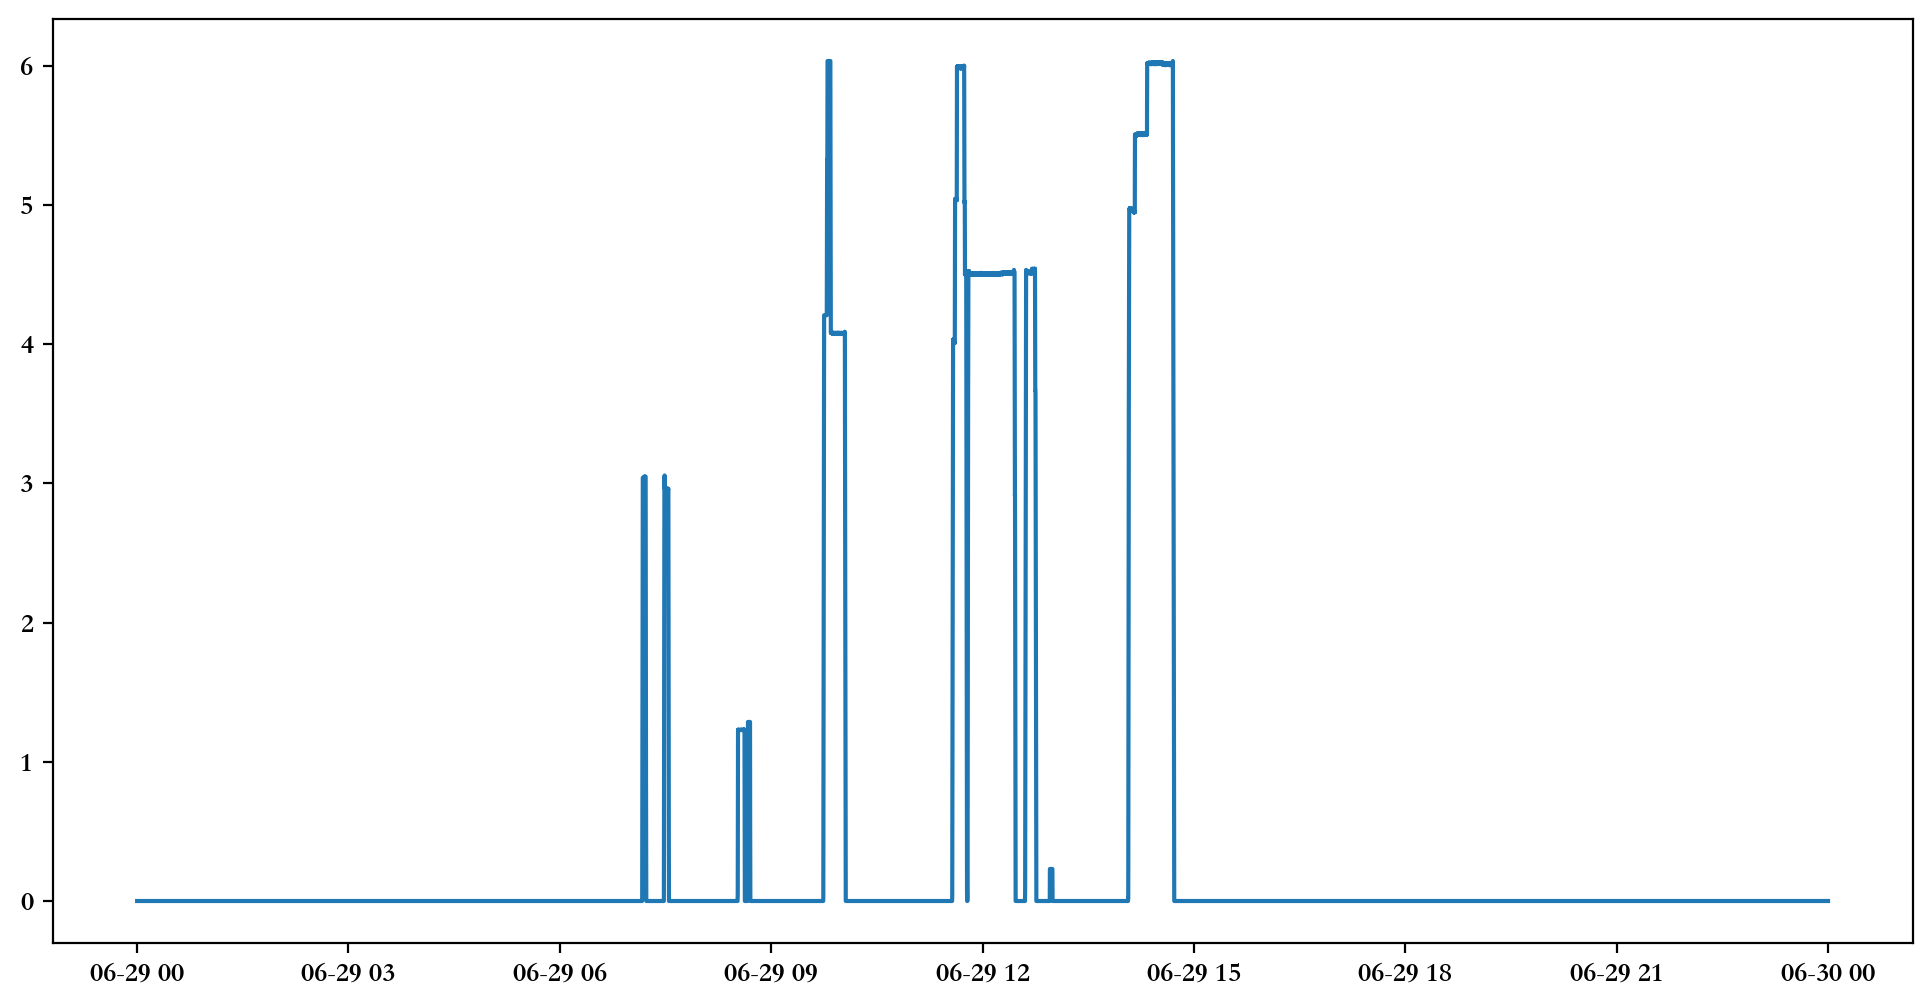

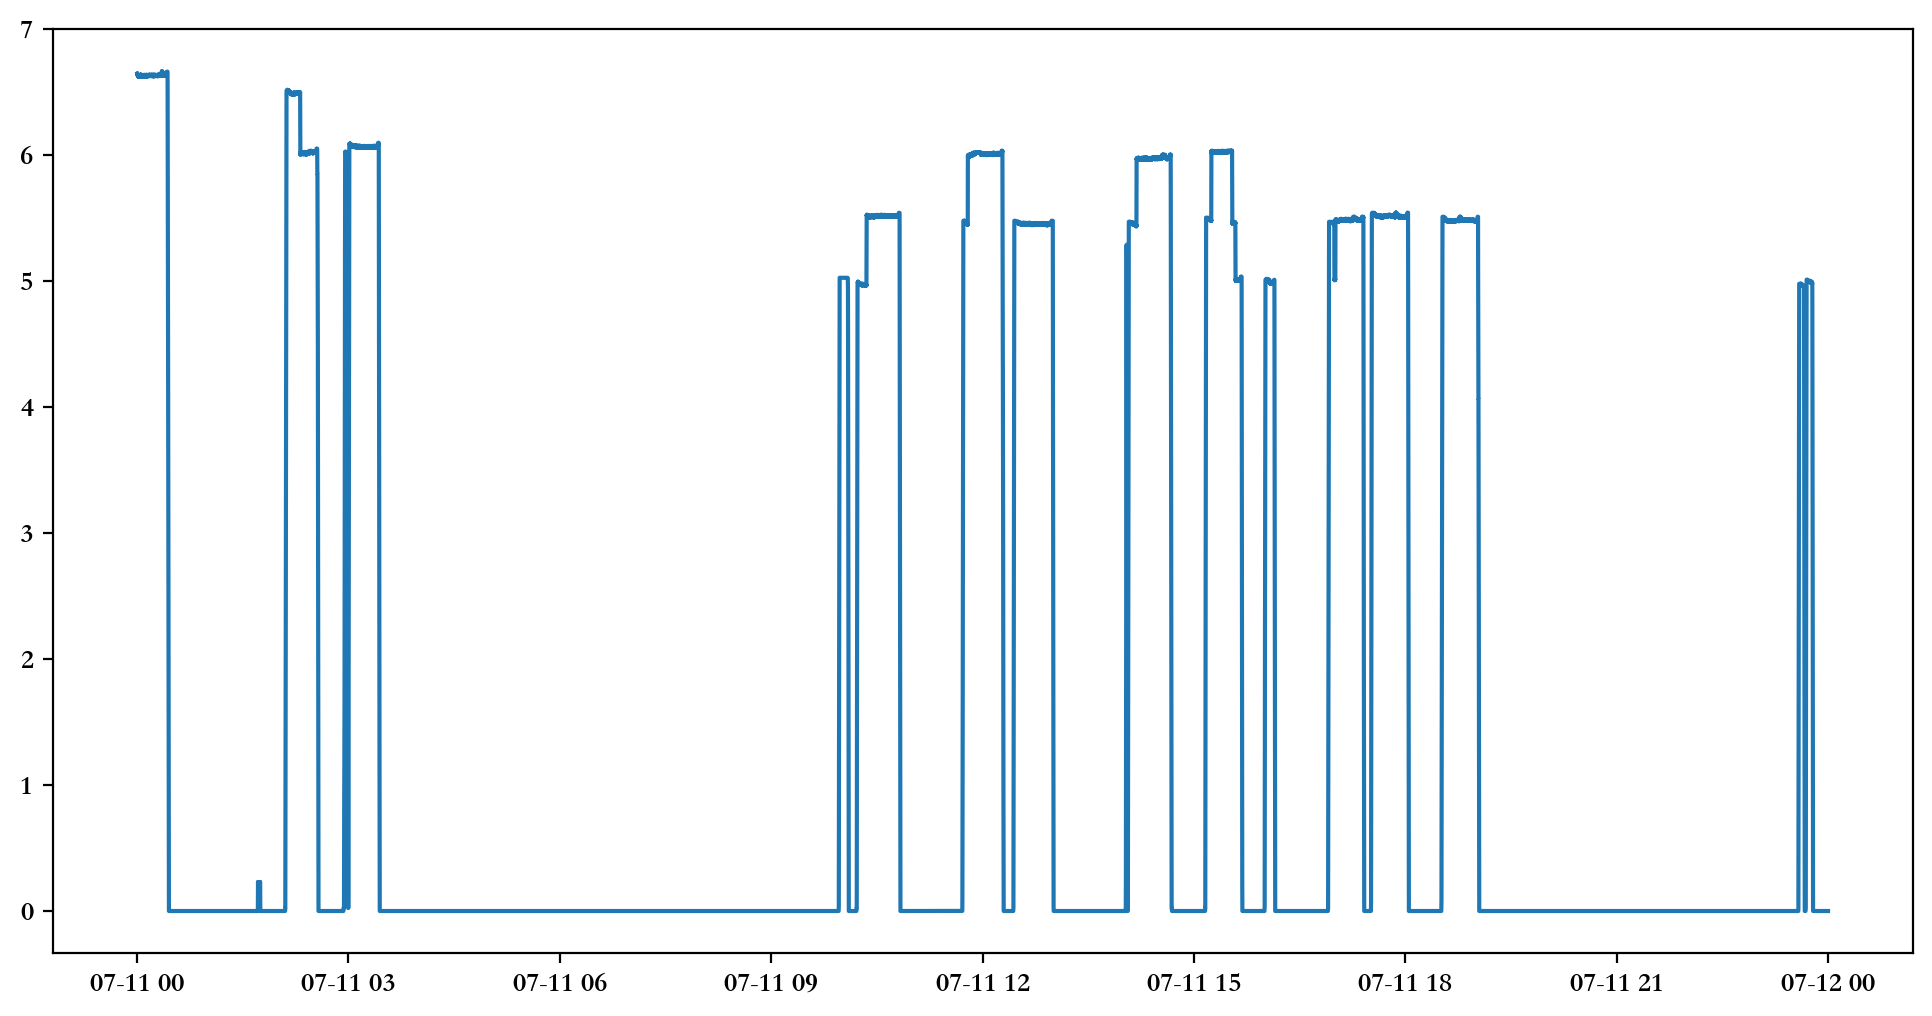

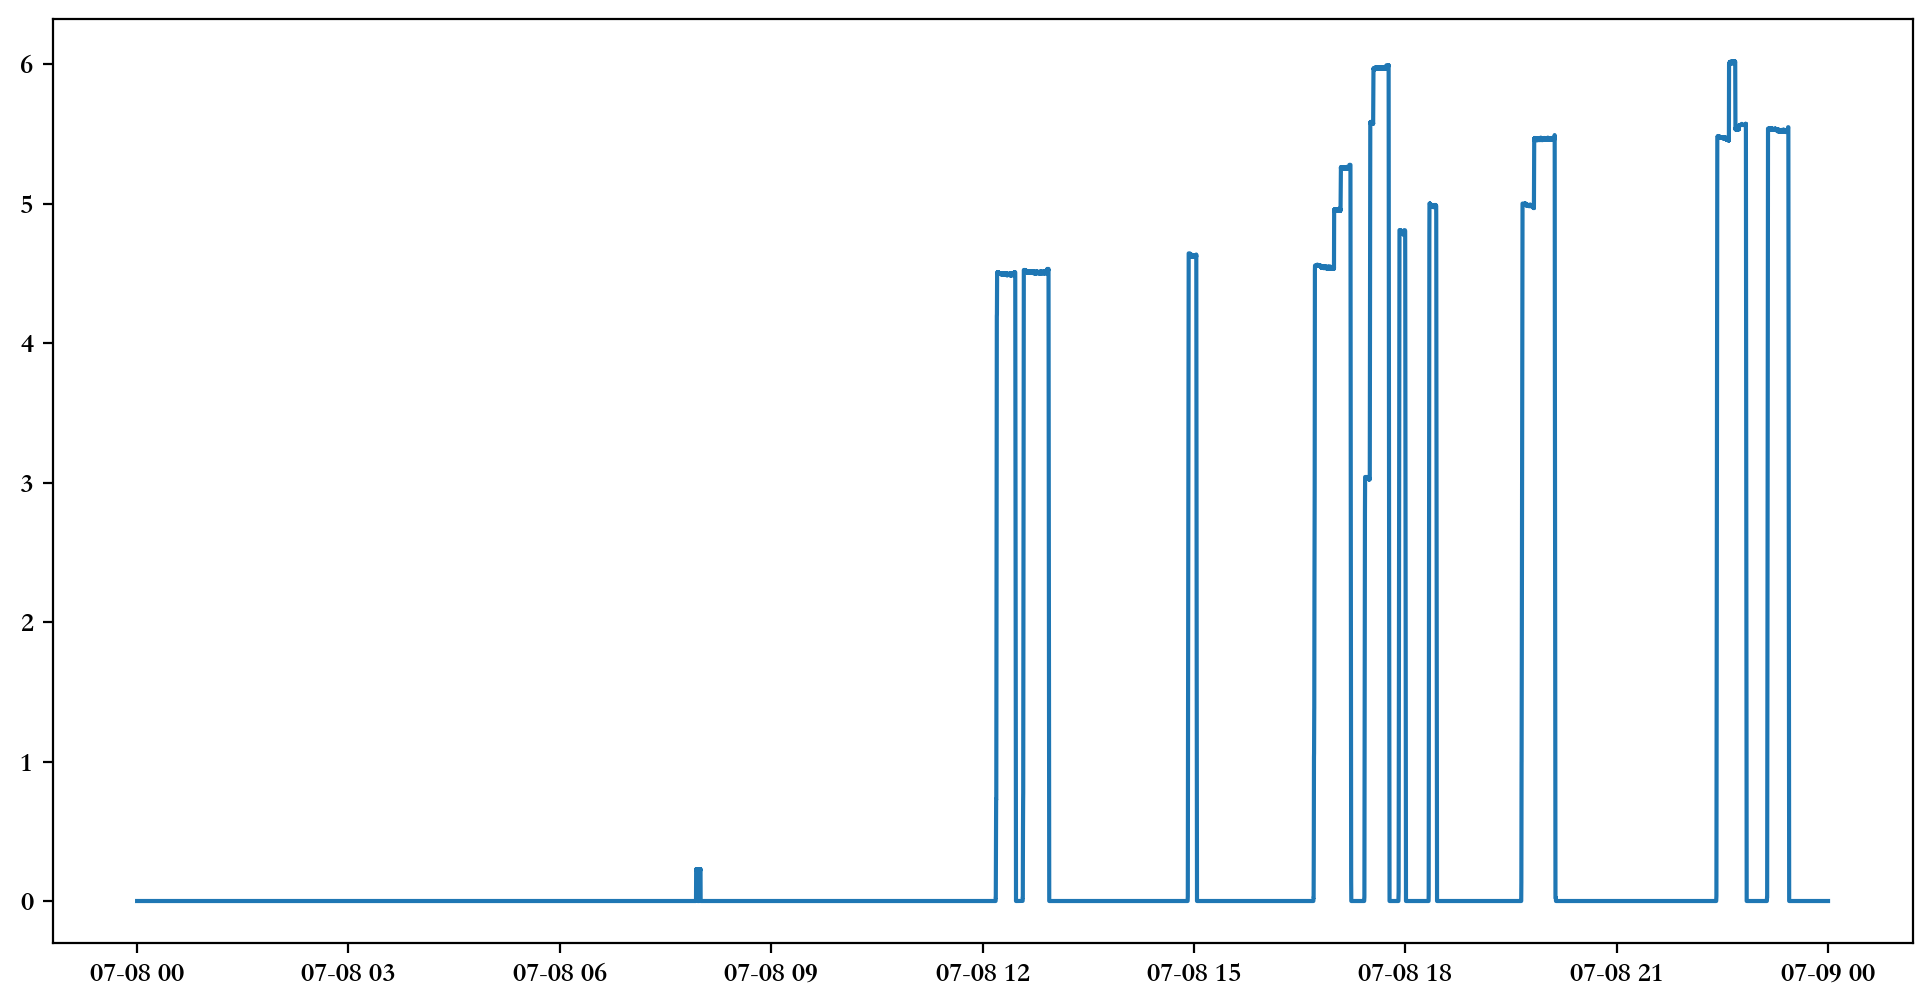

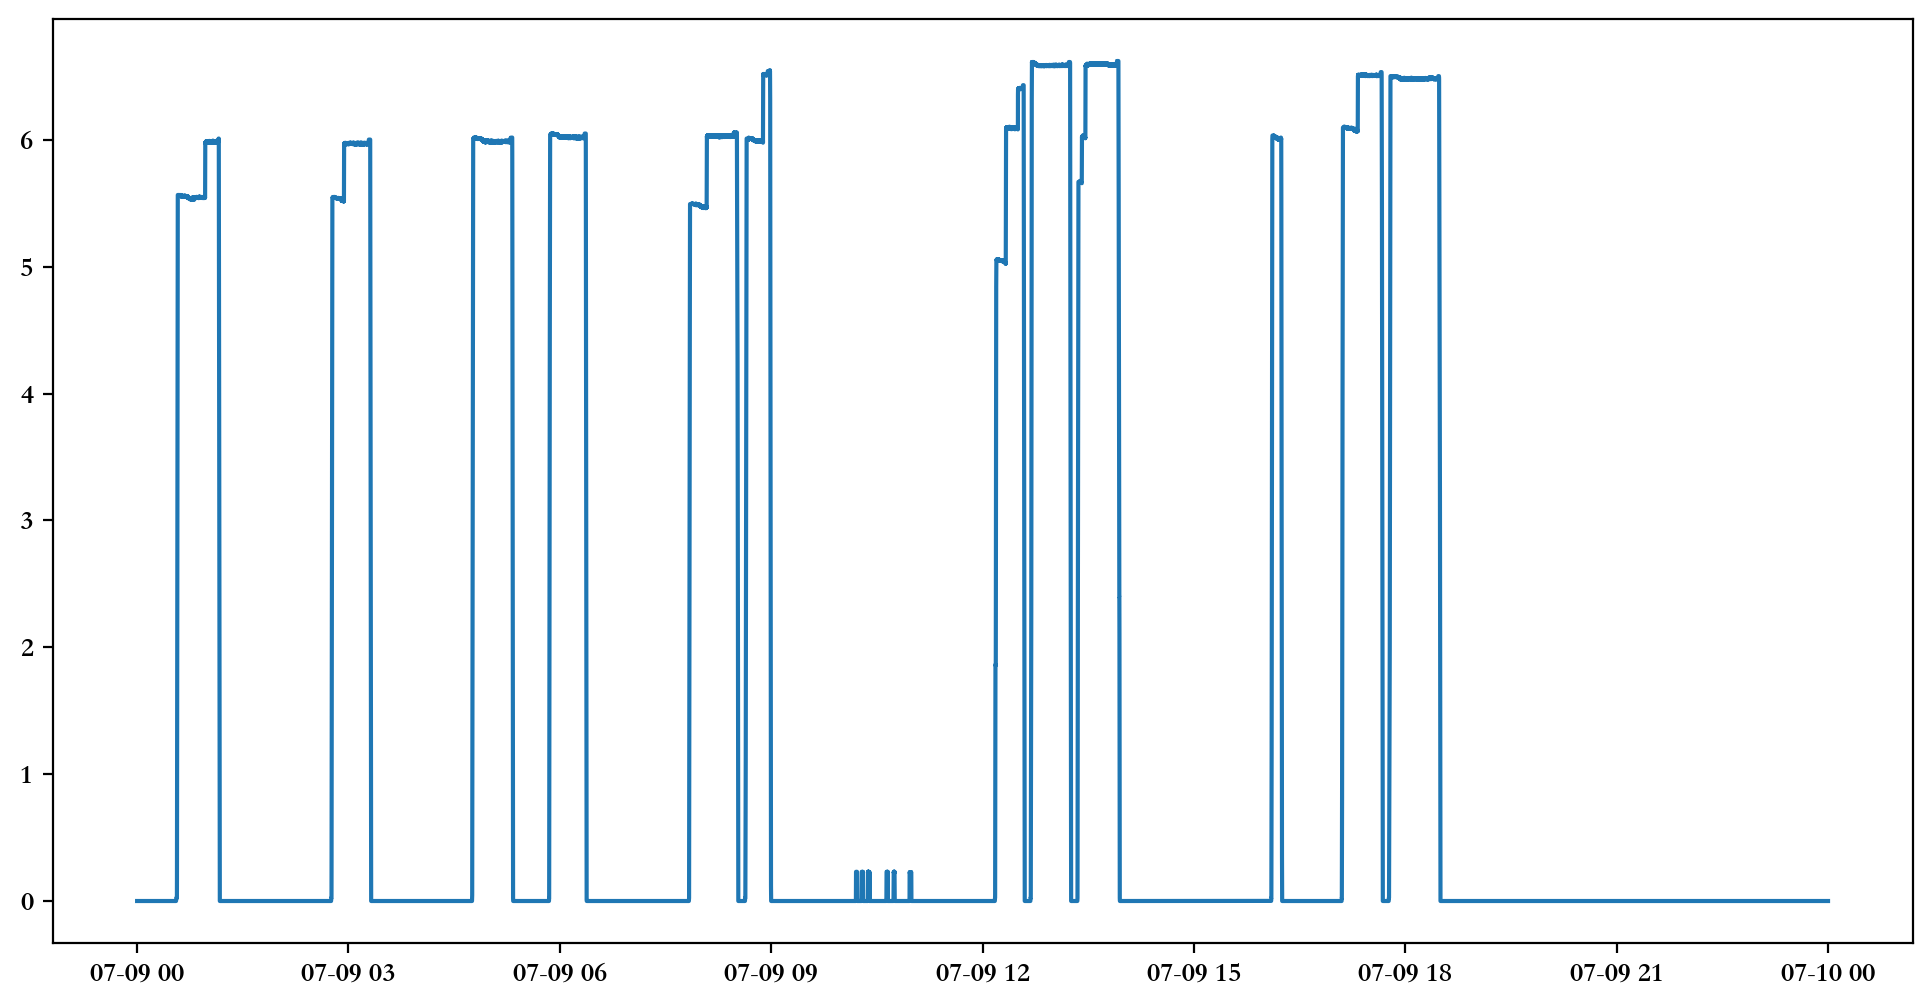

In [20]:
data = []
input_folder = '/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/un_zip'
output_folder = '/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/processed'
for file in list_of_bc:
    df = read_tbm_data('/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/un_zip/'+file)
    #取出这天的循环列表，方便我后面用手段对数据进行划分
    cycle_list = tbm_cycle_judge(df)
    df = data_presv(df,cycle_list,col_names=['推进速度','贯入度'],outlier_window = 5,smooth_window = 5)
    #save_process(df,file,output_folder,)
    phase_list = classify_excavation_phase(df,cycle_list,T_threshold = 0,Tf_threshold = 600,Ff_threshold = 1000,sigma_threshold = 20,duration_threshold = 60,v_set_rate = 0)
    save_process(df,phase_list,output_folder)
    data += phase_list
    plt.figure(figsize=(12, 6),dpi=200)
    plt.plot(df['运行时间'], df['刀盘转速'])

In [24]:
fp = '/Users/xudongzuo/Library/CloudStorage/OneDrive-个人/文档/workspace/test_data/processed/data_process'
df = pd.read_csv(fp, sep=',',index_col=False)

In [25]:
df

,时间戳,运行时间,刀盘转速,推进速度,刀盘扭矩,贯入度,总推进力,推进速度电位器设定值,is_extract,smoothing,cycle_id,phase_label
0,1436239077000,2015-07-07 11:17:57,5.014110565185547,38.80546875,613.762451171875,7.741239833831787,5637.1083984375,1592.5203857421875,True,True,2,rising
1,1436239078000,2015-07-07 11:17:58,5.015698432922363,38.3644775390625,611.2366333007812,7.652509117126465,5863.2294921875,1592.1585693359375,True,True,2,rising
2,1436239079000,2015-07-07 11:17:59,5.014110088348389,37.703173828125,625.5493774414062,7.520292949676514,6020.03662109375,1592.5203857421875,True,True,2,rising
3,1436239080000,2015-07-07 11:18:00,5.012521743774414,37.0417236328125,599.44970703125,7.389490413665771,5959.8134765625,1592.8819580078125,True,True,2,rising
4,1436239081000,2015-07-07 11:18:01,5.010933876037598,36.8212646484375,622.1817016601562,7.346246719360352,6183.66162109375,1592.8819580078125,True,True,2,rising
...,...,...,...,...,...,...,...,...,...,...,...,...
11171,1498718514000,2017-06-29 14:41:54,6.018519878387451,9.2607421875,1856.4420166015625,1.5404857635498046,0.0,1871.744873046875,False,True,12,stable
11172,1498718515000,2017-06-29 14:41:55,6.01951265335083,0.0,1579.448974609375,0.0,0.0,1871.744873046875,False,True,12,stable
11173,1498718516000,2017-06-29 14:41:56,6.02646017074585,0.0,1230.8924560546875,0.0,0.0,1871.744873046875,False,True,12,stable
11174,1498718517000,2017-06-29 14:41:57,6.02646017074585,0.0,922.7484130859376,0.0,0.0,1871.744873046875,False,True,12,stable


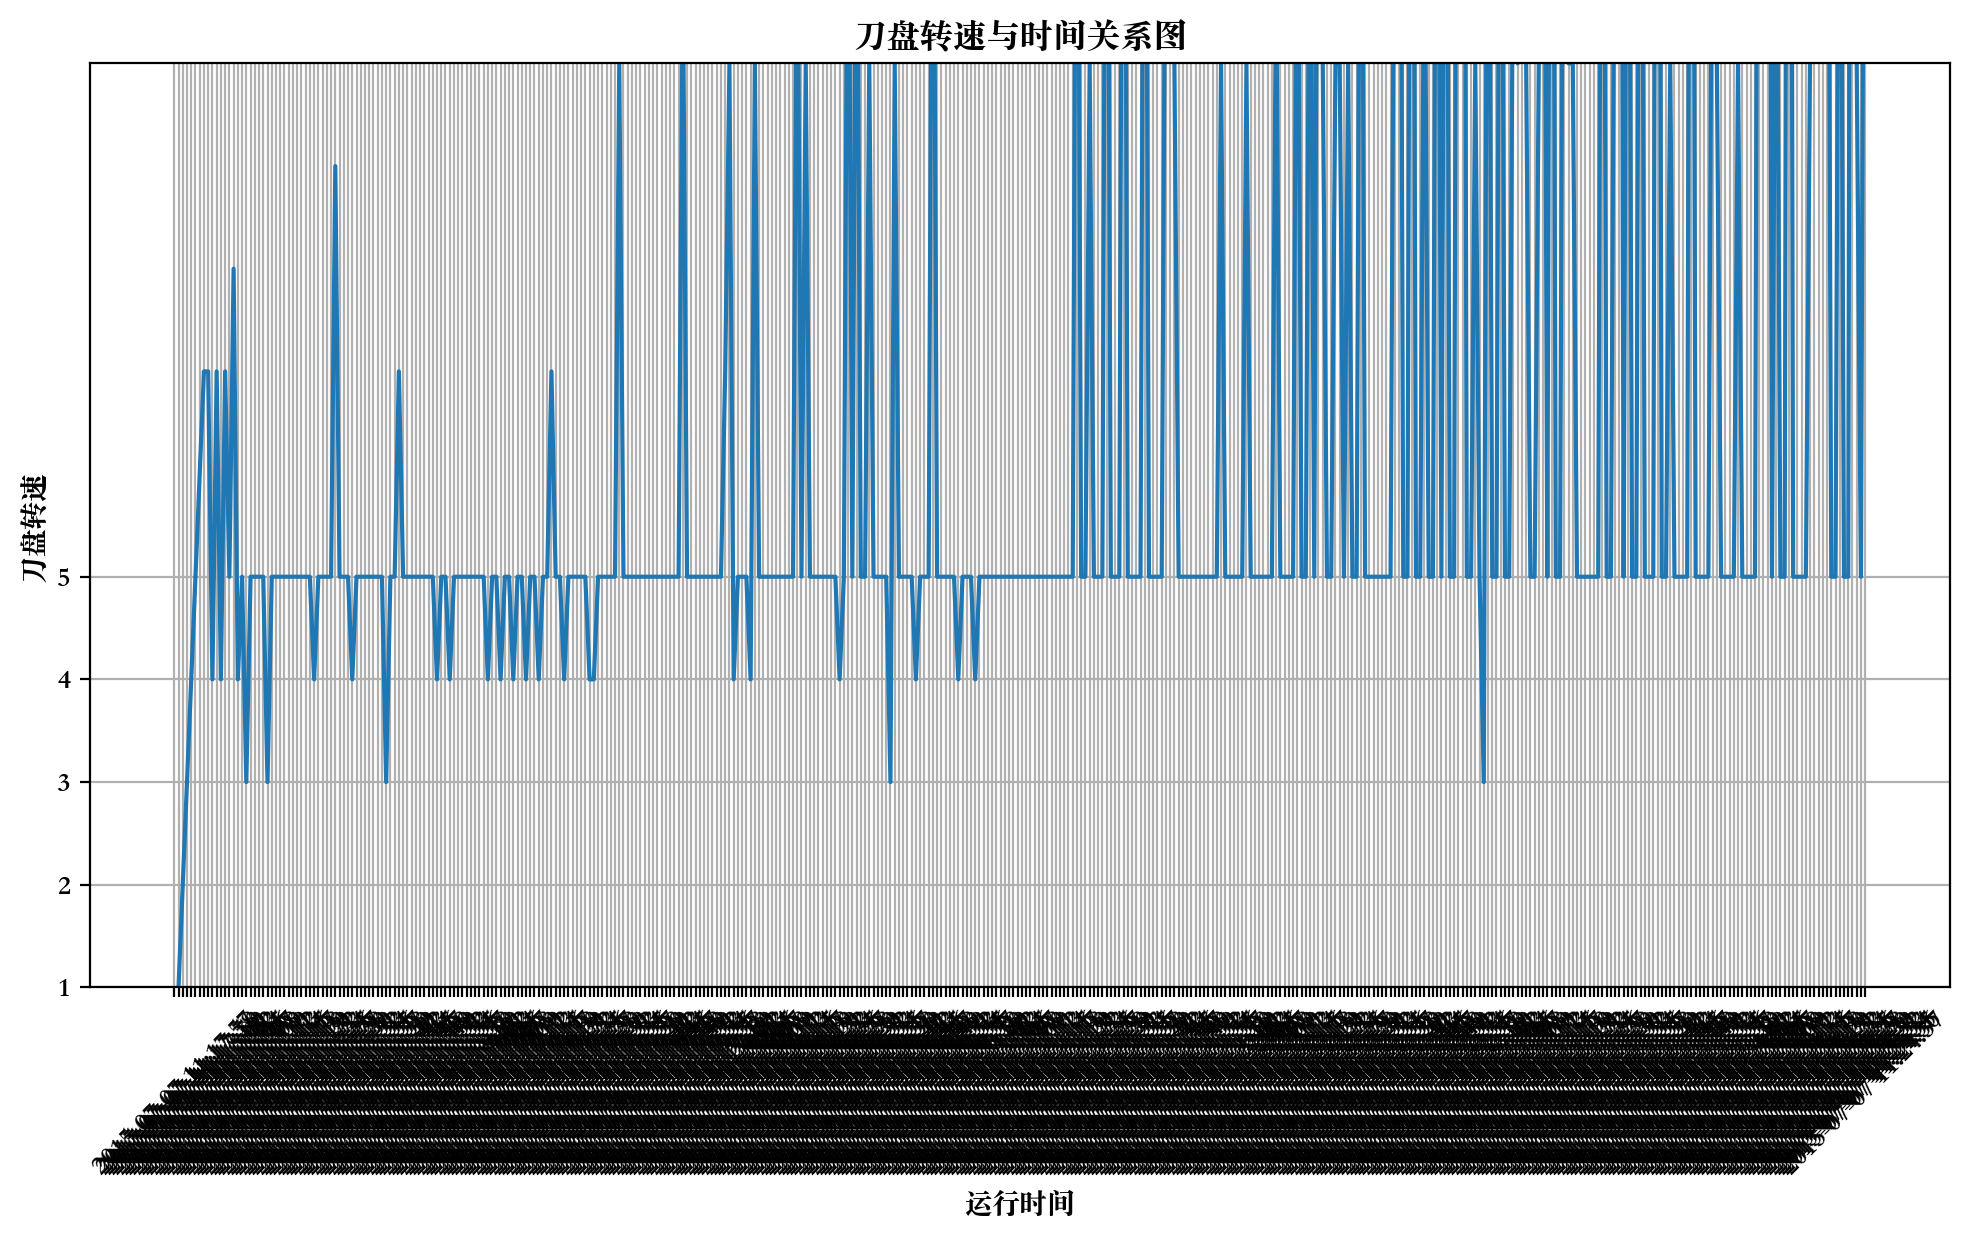

In [41]:
import matplotlib.dates as mdates
plt.figure(figsize=(12, 6),dpi=200)

df1 = df.copy()[:400]
plt.plot(df1['运行时间'], df1['刀盘转速'])
ax1 = plt.gca()

ax1.set_title('刀盘转速与时间关系图')
ax1.set_xlabel('运行时间')
ax1.set_ylabel('刀盘转速')

# 固定 y 轴范围，确保只在 1 到 5 之间显示
ax1.set_ylim(1, 10)
# 设置 y 轴主刻度
ax1.set_yticks([1, 2, 3, 4, 5])
ax1.set_yticklabels(['1', '2', '3', '4', '5']) # 直接指定标签为字符串
#ax1.set_ylim(1, 10)



plt.xticks(rotation=45)  # 旋转刻度，避免重叠


plt.grid() #开启网格
plt.show()

In [21]:
data

[{'cycle_id': 2,
  'push_start': Timestamp('2015-07-13 00:13:07'),
  'rising_start': Timestamp('2015-07-13 00:15:17'),
  'stable_start': Timestamp('2015-07-13 00:17:08'),
  'falling_start': Timestamp('2015-07-13 00:43:51')},
 {'cycle_id': 4,
  'push_start': Timestamp('2015-07-13 01:12:16'),
  'rising_start': Timestamp('2015-07-13 01:14:14'),
  'stable_start': Timestamp('2015-07-13 01:15:15'),
  'falling_start': Timestamp('2015-07-13 01:44:55')},
 {'cycle_id': 6,
  'push_start': Timestamp('2015-07-13 02:36:21'),
  'rising_start': Timestamp('2015-07-13 02:38:10'),
  'stable_start': Timestamp('2015-07-13 02:39:11'),
  'falling_start': Timestamp('2015-07-13 03:08:26')},
 {'cycle_id': 8,
  'push_start': Timestamp('2015-07-13 03:29:23'),
  'rising_start': Timestamp('2015-07-13 03:31:23'),
  'stable_start': Timestamp('2015-07-13 03:34:39'),
  'falling_start': Timestamp('2015-07-13 03:59:24')},
 {'cycle_id': 10,
  'push_start': Timestamp('2015-07-13 04:22:54'),
  'rising_start': Timestamp('201

In [27]:
plot_cycle_phases(df, phase_list, tbm_param='刀盘扭矩', buffer_minutes=0)

TypeError: '>=' not supported between instances of 'str' and 'Timestamp'

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假设我们使用上升段的时间序列数据作为输入
# 定义序列长度（时间步数）
time_steps = 60  # 例如，60秒的序列

# 提取上升段序列数据
# 假设上升段的时间范围内有足够的数据点
input_features = ['刀盘转速', '推进速度', '总推进力', '刀盘扭矩', '贯入度']
output_features = ['avg_stable_torque', 'avg_stable_thrust']

# 创建输入和输出列表
X = []
y = []

for phase in data:
    cycle_id = phase['cycle_id']
    rising_start = phase['rising_start']
    stable_start = phase['stable_start']
    falling_start = phase['falling_start']

    # 提取上升段数据
    rising_data = df[(df['运行时间'] >= rising_start) & (df['运行时间'] < stable_start)]

    # 确保有足够的时间步
    if len(rising_data) < time_steps:
        continue  # 或者使用填充
    else:
        # 滚动窗口生成序列
        for i in range(len(rising_data) - time_steps + 1):
            seq = rising_data.iloc[i:i+time_steps][input_features].values
            X.append(seq)

            # 对应的稳定段参数
            stable_data = df[(df['运行时间'] >= stable_start) & (df['运行时间'] < falling_start)]
            if not stable_data.empty:
                avg_stable_torque = stable_data['刀盘扭矩'].mean()
                avg_stable_thrust = stable_data['总推进力'].mean()
                y.append([avg_stable_torque, avg_stable_thrust])
            else:
                y.append([np.nan, np.nan])  # 处理缺失值

# 转换为numpy数组
X = np.array(X)
y = np.array(y)

# 移除包含NaN的样本
valid_indices = ~np.isnan(y).any(axis=1)
X = X[valid_indices]
y = y[valid_indices]

print(f'Input shape: {X.shape}')
print(f'Output shape: {y.shape}')

Input shape: (88, 60, 5)
Output shape: (88, 2)
